# 1. Подготовка данных

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (17, 6)


Отобразим базовую информацию о данных

In [2]:
df = pd.read_csv("./autos.csv", index_col = "id")
display(df.describe().T)
display(df.info())

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Видим, что данные заполнены неоднородно, в некоторых колонках наблюдается значительное число пропусков, также заметны нерелевантные данные.  
Хорошо видно несоответствие данных в колонках Power и RegistrationYear, например для колонки Power видим среднее значение 110, а максимальное 20000. Данные нуждаются в дополнительной предобработке.

Отобразим численные данные в гистограммах  
Возьмем срез по данным для колонки RegistrationYear

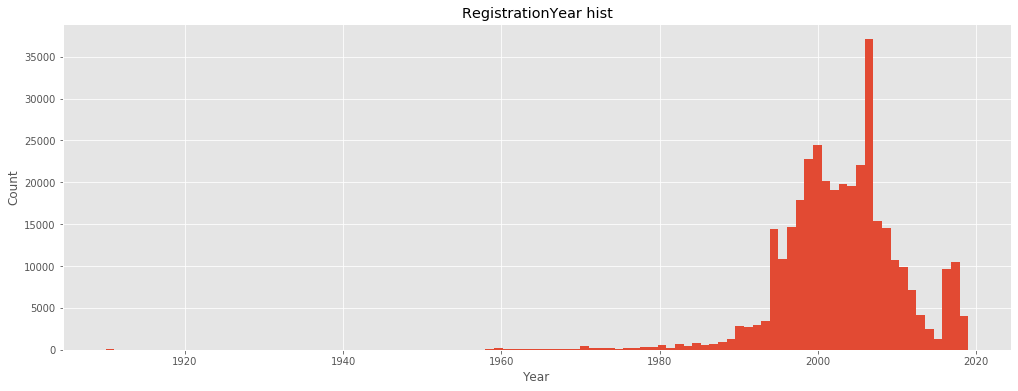

In [3]:
plot = df[(df["RegistrationYear"] > 1900) & (df["RegistrationYear"] < 2050)]["RegistrationYear"].hist(bins=100)
plt.title("RegistrationYear hist")
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Видим, что в основном набор данных находится начиная с 1960 года. \
Возьмем аналогично для колонки Power  

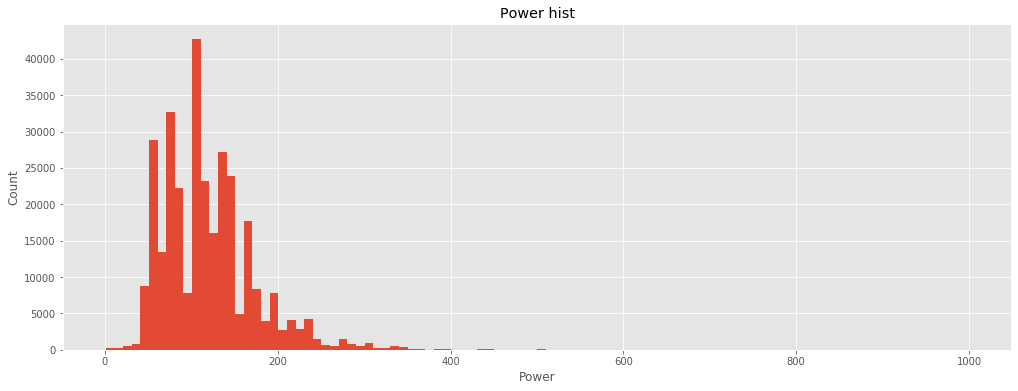

In [4]:
df[(df["Power"] > 0) & (df["Power"] < 1000)]["Power"].hist(bins=100)
plt.title("Power hist")
plt.xlabel('Power')
plt.ylabel('Count')
plt.show()

Запомним разброс основного набора данных, от 0 до 500.

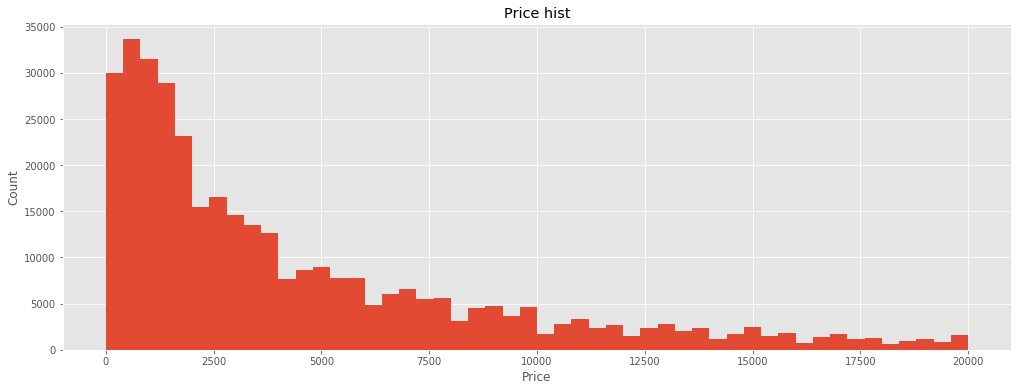

In [5]:
df["Price"].hist(bins=50)
plt.title("Price hist")
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

Сохраним данные по колонке Price

Уберем признаки, которые не помогут нам в построении точных моделей:
- DateCrawled - Дата сбора информации не влияет на качество модели
- NumberOfPictures - Нулевые значения во всех строках
- RegistrationMonth - Незначительные данные
- PostalCode - Колонка не влияющая на цену
- LastSeen - Колонка не влияющая на цену

In [6]:
df = df.loc[:,'Price':'NotRepaired'].drop(columns=['RegistrationMonth'])

Ограничим крайние значения в датафрейме, возьмем год начиная с 1960, Power с 30 до 500

In [7]:
df = df.query('RegistrationYear > 1960 and RegistrationYear < 2020 and Power < 500 and Power > 30  and Price > 50')
display(df.describe().T)
display(df.info())

,count,mean,std,min,25%,50%,75%,max
Price,304758.0,4823.844171,4583.344361,55.0,1350.0,3150.0,6950.0,20000.0
RegistrationYear,304758.0,2003.377378,6.745616,1961.0,1999.0,2003.0,2008.0,2019.0
Power,304758.0,120.395652,53.051294,31.0,75.0,110.0,150.0,490.0
Kilometer,304758.0,128645.367800,36458.444138,5000.0,125000.0,150000.0,150000.0,150000.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 304758 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             304758 non-null  int64 
 1   VehicleType       283781 non-null  object
 2   RegistrationYear  304758 non-null  int64 
 3   Gearbox           298876 non-null  object
 4   Power             304758 non-null  int64 
 5   Model             292763 non-null  object
 6   Kilometer         304758 non-null  int64 
 7   FuelType          285392 non-null  object
 8   Brand             304758 non-null  object
 9   NotRepaired       258358 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.6+ MB


None

Удалим оставшиеся нулевые данные, они не представляют особой ценности

In [8]:
df = df.dropna().reset_index(drop=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
1,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
2,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
4,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
...,...,...,...,...,...,...,...,...,...,...
232222,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
232223,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
232224,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
232225,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no


Проверим, все ли хорошо с нашими данными

In [9]:
display(df.describe().T)
display(df.info())

,count,mean,std,min,25%,50%,75%,max
Price,232227.0,5298.835243,4726.115588,55.0,1590.0,3699.0,7750.0,20000.0
RegistrationYear,232227.0,2003.140513,5.949206,1961.0,1999.0,2004.0,2007.0,2018.0
Power,232227.0,123.032063,53.085674,31.0,82.0,116.0,150.0,490.0
Kilometer,232227.0,127128.197841,36950.371647,5000.0,125000.0,150000.0,150000.0,150000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232227 entries, 0 to 232226
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             232227 non-null  int64 
 1   VehicleType       232227 non-null  object
 2   RegistrationYear  232227 non-null  int64 
 3   Gearbox           232227 non-null  object
 4   Power             232227 non-null  int64 
 5   Model             232227 non-null  object
 6   Kilometer         232227 non-null  int64 
 7   FuelType          232227 non-null  object
 8   Brand             232227 non-null  object
 9   NotRepaired       232227 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.7+ MB


None

Обратим внимание на подозрительные значения колонки Kilometer. Выведем уникальные значения колонки

In [10]:
df["Kilometer"].unique()

array([150000,  90000,  70000, 100000,  60000,   5000,  20000, 125000,
        80000,  50000,  40000,  10000,  30000], dtype=int64)

Т.к. в колонке лежат уникальные значения можем считать, что колонка категориальная.

Все вроде бы ок, однако категориальные значения необходимо заменить на численные. \
Воспользуемся LabelEncoder для преобразования

In [11]:
categorical_features = ["VehicleType","Gearbox", "Model", "Kilometer", "FuelType", "Brand", "NotRepaired"]
le = LabelEncoder()
df[categorical_features] = df[categorical_features].apply(lambda col: le.fit_transform(col))
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1500,5,2001,1,75,116,12,6,37,0
1,3600,5,2008,1,69,101,9,2,31,0
2,650,4,1995,1,102,11,12,6,2,1
3,2200,1,2004,1,109,8,12,6,25,0
4,2000,4,2004,1,105,10,12,6,19,0
...,...,...,...,...,...,...,...,...,...,...
232222,1490,5,1998,1,50,143,12,6,37,0
232223,7900,4,2010,1,140,116,12,2,37,0
232224,3200,4,2004,1,225,140,12,6,30,1
232225,1199,1,2000,0,101,106,11,6,32,0


Все отлично, можно двигаться к обучению моделей.

# 2. Обучение моделей

Разделим выборку на тренировочную, тестовую и финальную и выделим целевой признак Price

In [12]:
target = df["Price"]
features = df.drop('Price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state = 12345)

features_final, features_test, target_final, target_test = train_test_split(features_test, 
                                                                              target_test, 
                                                                              test_size=0.5, 
                                                                              random_state = 12345)

Выделим функцию отображения rmse для полученных предсказаний.

In [13]:
def print_rmse(target_predice, target_test):
    print(calculate_rmse(target_predice,target_test))

def calculate_rmse(target_predice, target_test):
    return mean_squared_error(target_predice,target_test) ** 0.5

### DecisionTreeRegressor

Для начала попробуем решить задачу с помощью DecisionTreeRegressor.  
Т.к. DecisionTreeRegressor выдает результат предсказания довольно быстро подберем такие параметры, которые приведут к наилучшему результату. Воспользуемся для этого GridSearchCV 

In [14]:
param_grid = {'max_depth': range(2,31,2),
              'min_samples_split': range(2,31,2)}

clf = GridSearchCV(DecisionTreeRegressor(), 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=5 , verbose=1)
clf.fit(features_train, target_train) 
clf.best_params_, clf.best_score_

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:  4.4min finished


({'max_depth': 28, 'min_samples_split': 30}, -3190755.609297821)

Применим полученные гиперпараметры к модели.

In [15]:
dt_regressor = DecisionTreeRegressor(random_state = 12345, max_depth = 28, min_samples_split = 30)

Вычислим время обучения модели и предсказания

In [16]:
%%time
dt_regressor.fit(features_train, target_train)

Wall time: 363 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=28,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=12345, splitter='best')

In [17]:
%%time
y_pred_dt = dt_regressor.predict(features_test)
print_rmse(y_pred_dt, target_test)

1787.5725774452278
Wall time: 18.6 ms


Получим хорошую скорость предсказания модели и удовлетворительный rmse

### LightBM

Выделим метод генерации дерева lightgbm. \
Передадим методу три параметра: max_bin, learning_rate, num_boost_round и вернем сгенерированное дерево.

In [18]:
def generate_lgbm(max_bin, learning_rate, num_boost_round):
    train_data = lightgbm.Dataset(features_train, label=target_train, categorical_feature=categorical_features)
    test_data = lightgbm.Dataset(features_test, label=target_test, categorical_feature=categorical_features)
    parameters = {
        'application': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'z': max_bin,
        'learning_rate': learning_rate
    }
    model = lightgbm.train(parameters,
                           train_data,
                           num_boost_round=num_boost_round)
    return model


Воспользуемся подсказкой по тюнингу гиперпараметров с сайта посвященному lightgbm  (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) и подготовим три разные модели. \
Для первой постараемся подобрать гиперпараметры таким образом, чтобы она максимально быстро выдавала правильный ответ. \
Для второй подбираем параметры близкие к параметрам по умолчанию, так, чтобы она давай примерно средней по производительности и точности результат.  
Для последней постараемся найти гиперпараметры дающие максимально точные значения.

Описания гиперпараметров найдем здесь: https://lightgbm.readthedocs.io/en/latest/Parameters.html

#### Модель  1 (быстрый результат)

In [19]:
%%time
model1 = generate_lgbm(150, 0.3, 300) 

Wall time: 1.83 s


In [20]:
%%time
print_rmse(model1.predict(features_test), target_test)

1523.9982096976312
Wall time: 264 ms


#### Модель 2 (сбалансированная)

In [21]:
%%time
model2 = generate_lgbm(255, 0.1, 1500)

Wall time: 8.16 s


In [22]:
%%time
print_rmse(model2.predict(features_test), target_test)

1494.7940433903007
Wall time: 1.33 s


#### Модель 3 (высокая точность)

In [23]:
%%time
model3 = generate_lgbm(400, 0.05, 2500)

Wall time: 13.2 s


In [24]:
%%time
print_rmse(model3.predict(features_test), target_test)

1492.075935646243
Wall time: 2.42 s


# 3. Анализ моделей

Как и ожидалось, первая модель хоть и показывает самую высокую оценку rmse, зато производит расчет крайне быстро. Обученную таким образом модель можно использовать для динамического прогнозирования цены пользователю, например, на специализированных сайтах или в мобильном приложении.

Вторая модель требует немного больше времени для расчетов, но предсказывает точнее (хоть и не столь значительно). Показывать результаты ее работы напрямую пользователю было бы не совсем корректно, неправильно заставлять пользователя ждать даже 10 секунд, однако модель с такой конфигурацией можно было бы применить во внутренних сервисах компании, для оценки стоимости автомобиля, там где не моментальный ответ допустим.


С третьей моделью мы вероятней всего столкнулись с проблемой переобучения. Rmse  ниже в рамках погрешности, а временные затраты для предсказания слишком велики. Использовать такую модель не представляется рациональным, лучше остановиться на первых двух. 

Основываясь на богатом наборе гиперпараметров lightgbm мы можем продолжать тестировать разные вариации для получение наилучшего результата. Например можно перебрать параметры num_leaves в сочетании с max_depth.

 #### Сравнения скорости и точности моделей LightBM и DecisionTreeRegressor

In [25]:
print_rmse(model1.predict(features_final), target_final)
print_rmse(model2.predict(features_final), target_final)
print_rmse(dt_regressor.predict(features_final), target_final)

1507.6968849595457
1477.1238801631168
1730.878001959136


In [26]:
%%time
model_pred = model1.predict(features_final)

Wall time: 305 ms


In [27]:
%%time
model2_pred = model2.predict(features_final)

Wall time: 1.42 s


In [28]:
%%time
dt_pred = dt_regressor.predict(features_final)

Wall time: 31.9 ms


|              	| rmse 	| evaluation time 	|
|:------------:	|:----:	|:---------------:	|
|    model1    	| 1507 	|      1.38 s     	|
|    model2    	| 1477 	|      8.6 s      	|
| dt_regressor 	| 1730 	|     16.5 ms     	|

С использованием lightgbm мы хоть и теряем в производительности модели, однако значительно приобретаем в ее точности. Необходимо отметить, что классические модели проще обучить и настроить, однако в реальной работе по всей видимости рационально использовать lightgbm с его богатством настроек.